In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.optimize as optimize

import emcee
import corner
import george
from george import kernels

import gaussianprocessregression as gpr

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import time

In [3]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),    # figure size in inches
    'text.usetex': True,
#     "font.family": 'serif',
#     "font.serif": ['Computer Modern'],
    'font.size': 14,
    #'axes.titlesize': 20,
    'axes.labelsize': 20,
    'axes.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.major.size': 8,
    'xtick.minor.size': 4, 
    'xtick.major.width': 2,
    'xtick.minor.width': 2,
    'xtick.direction': 'out',
    'ytick.major.size': 8,
    'ytick.minor.size': 4, 
    'ytick.major.width': 2,
    'ytick.minor.width': 2,
    'ytick.direction': 'out',  
    #'axes.prop_cycle'    : cycler('color', 'bgrcmyk'),
    })

# Simple 1D example

In [141]:
#x = np.random.uniform(-6.0, 7.0, 20)
x = np.linspace(-6.0, 7.0, 20)

def func(x):
    return np.sin(x*(1.0+0.05*x)) + 0.5*x + 10

sigma = 0.1
y = func(x) + np.random.normal(0.0, sigma, x.shape)

params = np.array([x]).T

In [142]:
ndim = 1
sigma_f = 5.0
sigma_n = 0.1
l0 = 3.0
k = sigma_f**2*kernels.ExpSquaredKernel([l0**2], ndim=ndim) + kernels.WhiteKernel(sigma_n**2, ndim=ndim)

In [143]:
# Set up the Gaussian process.
gp = george.GP(k, solver=george.HODLRSolver)

# You need to compute the GP once before starting the optimization.
gp.compute(params)

gp.kernel.pars, np.exp(gp.kernel.vector), gp.kernel.vector, gp.kernel, np.exp(gp.kernel[:])**0.5

(array([  2.50000000e+01,   9.00000000e+00,   1.00000000e-02]),
 array([  2.50000000e+01,   9.00000000e+00,   1.00000000e-02]),
 array([ 3.21887582,  2.19722458, -4.60517019]),
 ConstantKernel(25.0, ndim=1) * ExpSquaredKernel(9.0, ndim=1) + WhiteKernel(0.01, ndim=1),
 array([ 5. ,  3. ,  0.1]))

In [144]:
def lnlike_gp(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(y, quiet=True)
    return ll


def lnprior_gp(p):
    lnsigmaf2, lnl02, lnsigman2 = p
    if not -10 < lnsigmaf2 < 10:
        return -np.inf
    if not -10 < lnl02 < 10:
        return -np.inf
    if not -10 < lnsigman2 < 10:
        return -np.inf
    return 0.0


def lnprob_gp(p):
    lp = lnprior_gp(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_gp(p)


def fit_gp(initial, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1.0 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp)

    print("Running burn-in")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1.0 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)

    return sampler

In [145]:
initial = np.array([0.0, 0.0, 0.0])
sampler = fit_gp(initial, nwalkers=32)

Running burn-in
Running second burn-in
Running production


[ 4.08341711  1.98032913 -4.77211728]
[ 7.70376025  2.69167739  0.09199154]


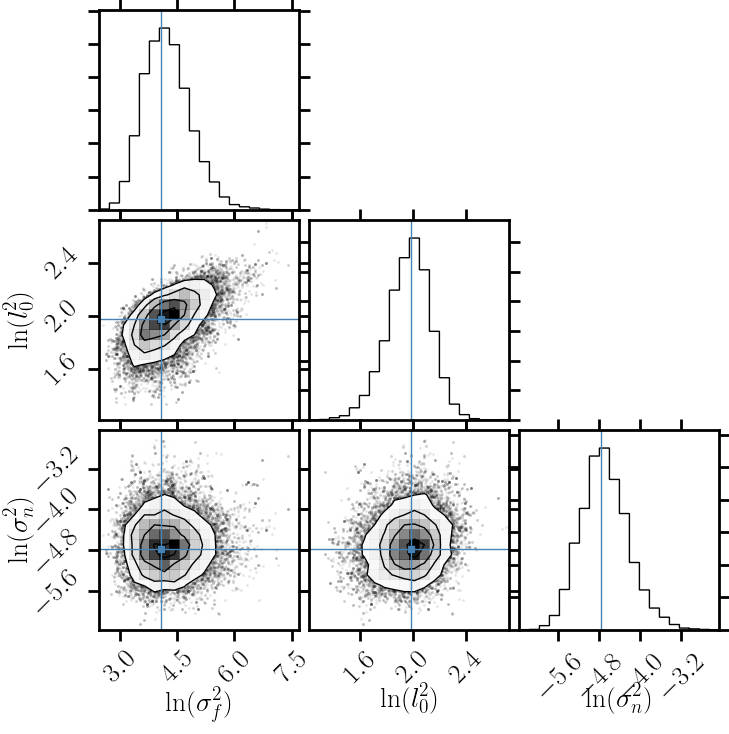

In [146]:
# Find Maximum likelihood
imax = sampler.lnprobability.argmax()
pmax = sampler.flatchain[imax]
print pmax
print np.exp(pmax)**0.5

# Make the corner plot.
samples = sampler.flatchain
labels = [r'$\ln(\sigma_f^2)$', r'$\ln(l_0^2)$', r'$\ln(\sigma_n^2)$']
fig = corner.corner(samples, truths=pmax, labels=labels)

False
True


(5.9589242746631381, 15.814484779937501)

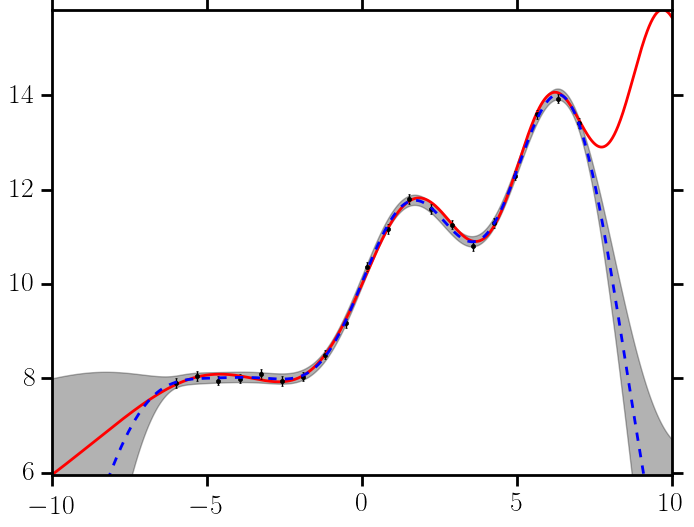

In [147]:
gp.kernel[:] = pmax

xall = np.linspace(-10, 10, 1000)
yall = func(xall)

xs = np.linspace(-10, 10, 1000)

print gp.computed
ys, cov = gp.predict(y, xs)
print gp.computed

ys_err = np.sqrt(np.diag(cov))

fig, axes = plt.subplots(figsize=(8, 6))
axes.plot(xall, yall, c='r', lw=2)
axes.errorbar(x, y, yerr=sigma, fmt=".k", capsize=1)
#axes.plot(x, y, 'bo')
axes.plot(xs, ys, c='b', ls='--', lw=2)
axes.fill_between(xs, ys-ys_err, ys+ys_err, color='k', alpha=0.3)
axes.set_ylim(np.min(yall), np.max(yall))

# 2D simple function with Latin hypercube sampling

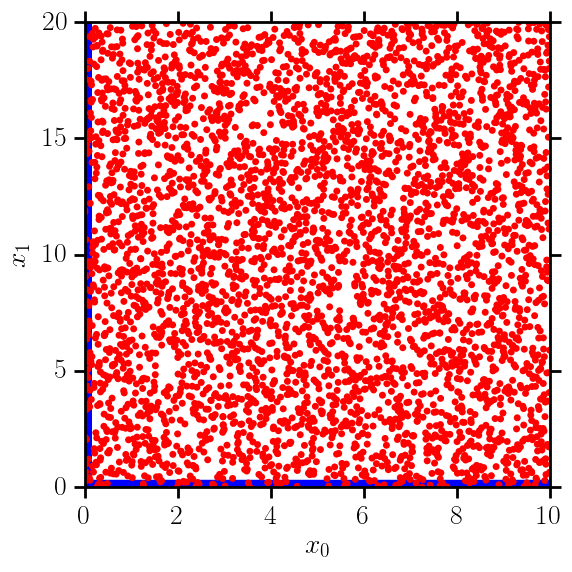

In [34]:
# Make 2d latin hypercube points
Ndata = 4096
limits = np.array([[0, 10], [0, 20]])
points = gpr.latin_hypercube(Ndata, limits)

# ******* plot data *******
fig = plt.figure(figsize=(6, 6))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(111)

# for p in points[:, 0]:
#     axes.axvline(p, c='grey', lw=1)

# for p in points[:, 1]:
#     axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=25)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$x_0$')
axes.set_ylabel(r'$x_1$')

In [45]:
params = points

# Generate data
def func(x, y):
    return (np.sin(x*(1.0+0.05*x)) + 0.5*x + 10)*0.01*(y-5.0)**2 - 0.1*x*y

nparams = len(params)
sigma = 1.0e-3
data = np.array([func(params[i, 0], params[i, 1]) for i in range(nparams)]) + np.random.normal(0.0, sigma, nparams)

In [46]:
np.log(sigma**2)

-13.815510557964274

In [47]:
ndim = 2
sigma_f = 3.0
sigma_n = 1.0e-3
l0 = 3
l1 = 10
k = sigma_f**2*kernels.ExpSquaredKernel([l0**2, l1**2], ndim=ndim) + kernels.WhiteKernel(sigma_n**2, ndim=ndim)

In [48]:
# Set up the Gaussian process.
gp = george.GP(k, solver=george.HODLRSolver)

# You need to compute the GP once before starting the optimization.
gp.compute(params)

gp.kernel.pars, np.exp(gp.kernel.vector), gp.kernel.vector, gp.kernel, np.exp(gp.kernel[:])**0.5

(array([  9.00000000e+00,   9.00000000e+00,   1.00000000e+02,
          1.00000000e-06]),
 array([  9.00000000e+00,   9.00000000e+00,   1.00000000e+02,
          1.00000000e-06]),
 array([  2.19722458,   2.19722458,   4.60517019, -13.81551056]),
 ConstantKernel(9.0, ndim=2) * ExpSquaredKernel(9.0, 100.0, ndim=2) + WhiteKernel(1e-06, ndim=2),
 array([  3.00000000e+00,   3.00000000e+00,   1.00000000e+01,
          1.00000000e-03]))

In [49]:
def lnlike_gp(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(data, quiet=True)
    return ll


def lnprior_gp(p):
    lnsigmaf2, lnl02, lnl12, lnsigman2 = p
    if not 0 < lnsigmaf2 < 7:
        return -np.inf
    if not 0 < lnl02 < 10:
        return -np.inf
    if not 0 < lnl12 < 10:
        return -np.inf
    if not -20 < lnsigman2 < -4:
        return -np.inf
    return 0.0


def lnprob_gp(p):
    lp = lnprior_gp(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_gp(p)


# def fit_gp(initial, nwalkers=32):
#     ndim = len(initial)
#     p0 = [np.array(initial) + 1.0 * np.random.randn(ndim)
#           for i in xrange(nwalkers)]
#     print p0
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp, threads=8)

#     print("Running burn-in")
#     p0, lnp, _ = sampler.run_mcmc(p0, 500)
#     sampler.reset()

#     print("Running second burn-in")
#     p = p0[np.argmax(lnp)]
#     p0 = [p + 1.0 * np.random.randn(ndim) for i in xrange(nwalkers)]
#     p0, _, _ = sampler.run_mcmc(p0, 500)
#     sampler.reset()

#     print("Running production")
#     p0, _, _ = sampler.run_mcmc(p0, 2000)

#     return sampler

In [50]:
nparams = 4
nwalkers = 64
nsteps = 1000
limits = np.array([[0, 7], [0, 10], [0, 10], [-20, -4]])

p0 = gpr.uniform_random_samples(nwalkers, limits)
sampler = emcee.EnsembleSampler(nwalkers, nparams, lnprob_gp, threads=8)

t0 = time.clock()

# Run the production chain.
sampler.run_mcmc(p0, nsteps)

t1 = time.clock()
t1-t0

19.881654

In [ ]:
def sample_walkers_centered(nwalkers, center, sigma, lnprior):
    """Place initial position of walkers uniformly in prior.
    This function removes points where lnprior is not 0.0.
    EMCEE walkers get lost if they start outside the prior region.
    
    Parameters
    ----------
    nwalkers : int
    center : shape (nparams,)
    sigma : shape (nparams,)
    """
    nparams = len(center)
    pos = []
    for i in range(nwalkers):
        while True:
            p = (center-sigma) + 2.0*sigma*np.random.rand(nparams)
            if lnprior(p) == 0.0:
                break
        pos+=[p]
        
    return np.array(pos)

In [ ]:
p0 = sample_walkers_centered(nwalkers, pmax, np.array([1.0, 1.0, 1.0, 1.0]), lnprior_gp)

In [ ]:
nparams = 4
nwalkers = 64
nsteps = 1000
sampler = emcee.EnsembleSampler(nwalkers, nparams, lnprob_gp, threads=8)

t0 = time.clock()

# Run the production chain.
sampler.run_mcmc(p0, nsteps)

t1 = time.clock()
t1-t0

In [ ]:
np.exp(8)**0.5

In [ ]:
# limits = np.array([[4, 8], [0, 3], [4, 6], [-20, -10]])
# def sample_walkers_uniformly_from_bounds(nwalkers, limits):
#     """Place initial position of walkers uniformly in prior.
#     This function removes points where lnprior is not 0.0.
#     EMCEE walkers get lost if they start outside the prior region.
#     """
#     pos = []
#     for i in range(nwalkers):
#         while True:
#             p = limits[:, 0] + (limits[:, 1]-limits[:, 0])*np.random.rand(ndim)
#             if lnprior(p, tpm_guess, dfmin) == 0.0:
#                 break
#         pos+=[p]
        
#     return pos

In [ ]:
# def sample_walkers_centered(nwalkers, center, sigma, lnprior, tpm_guess, dfmin):
#     """Place initial position of walkers uniformly in prior.
#     This function removes points where lnprior is not 0.0.
#     EMCEE walkers get lost if they start outside the prior region.
#     """
#     pos = []
#     for i in range(nwalkers):
#         while True:
#             p = (center-sigma) + 2.0*sigma*np.random.rand(ndim)
#             if lnprior(p, tpm_guess, dfmin) == 0.0:
#                 break
#         pos+=[p]
        
#     return pos

In [ ]:
# initial = array([6, 2, 5, -15.0])
# sampler = fit_gp(initial, nwalkers=32)

In [4]:
def max_lnprobability(sampler, nburnin=0):
    """Find the parameters corresponding to the maximum value of the ln(probability).
    Optionally ignore the first nburnin samples.
    """
    # 1st index: walker/chain number
    # 2nd index: iteration number
    # 3rd index: parameter number
    samples = sampler.chain[:, nburnin:, :]
    lnprob = sampler.lnprobability[:, nburnin:]
    iflat = lnprob.argmax()
    indices = np.unravel_index(iflat, lnprob.shape)
    return samples[indices], lnprob[indices]

In [66]:
max_lnprobability(sampler, nburnin=500)

(array([  6.42504459,   7.36019218,   4.49520613, -19.57993557]),
 300914891867.20221)

[  6.42504459   7.36019218   4.49520613 -19.57993557]
[  2.48416653e+01   3.96502038e+01   9.46502158e+00   5.60107015e-05]


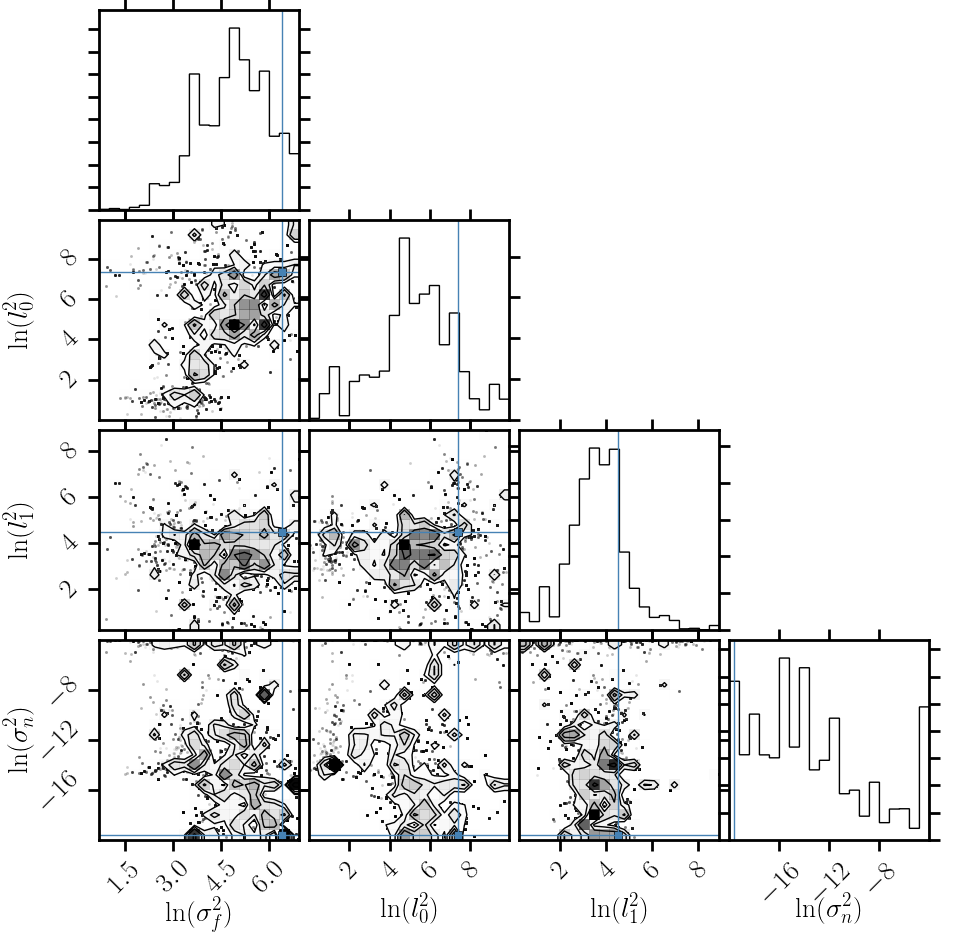

In [51]:
# Make the corner plot.
nburnin = 50
samples = sampler.chain[:, nburnin:, :].reshape((-1, nparams))

# Find Maximum likelihood
lnprobflat = sampler.lnprobability[:, nburnin:].reshape(-1)
imax = np.argmax(lnprobflat)

params_max = samples[imax]
#imax = sampler.lnprobability.argmax()
pmax = samples[imax]
print pmax
print np.exp(pmax)**0.5

#samples = sampler.flatchain
labels = [r'$\ln(\sigma_f^2)$', r'$\ln(l_0^2)$', r'$\ln(l_1^2)$', r'$\ln(\sigma_n^2)$']
fig = corner.corner(samples, truths=pmax, labels=labels)

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in sqrt


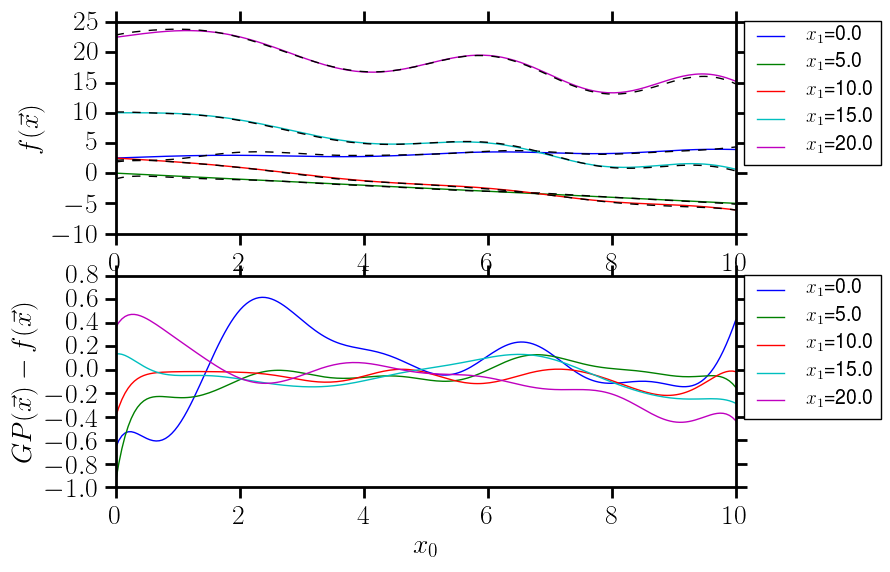

In [52]:
#gp.kernel[:] = pmax
gp.kernel[:] = [4.8, 1.4, 5.0, -16]

fig, ax = plt.subplots(2, figsize=(8, 6))
for y in np.linspace(0, 20, 5):
    xs = np.linspace(0, 10, 200)
    ps = np.array([[x, y] for x in xs])
    
    true = np.array([func(p[0], p[1]) for p in ps])
    
    interp, cov = gp.predict(data, ps)
    interp_err = np.sqrt(np.diag(cov))
    
    ax[0].plot(xs, true, label=r'$x_1$='+str(y))
    ax[0].plot(xs, interp, c='k', ls='--')
    
    ax[1].plot(xs, (interp-true), label=r'$x_1$='+str(y))


ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))

# 3D simple function with Latin hypercube sampling

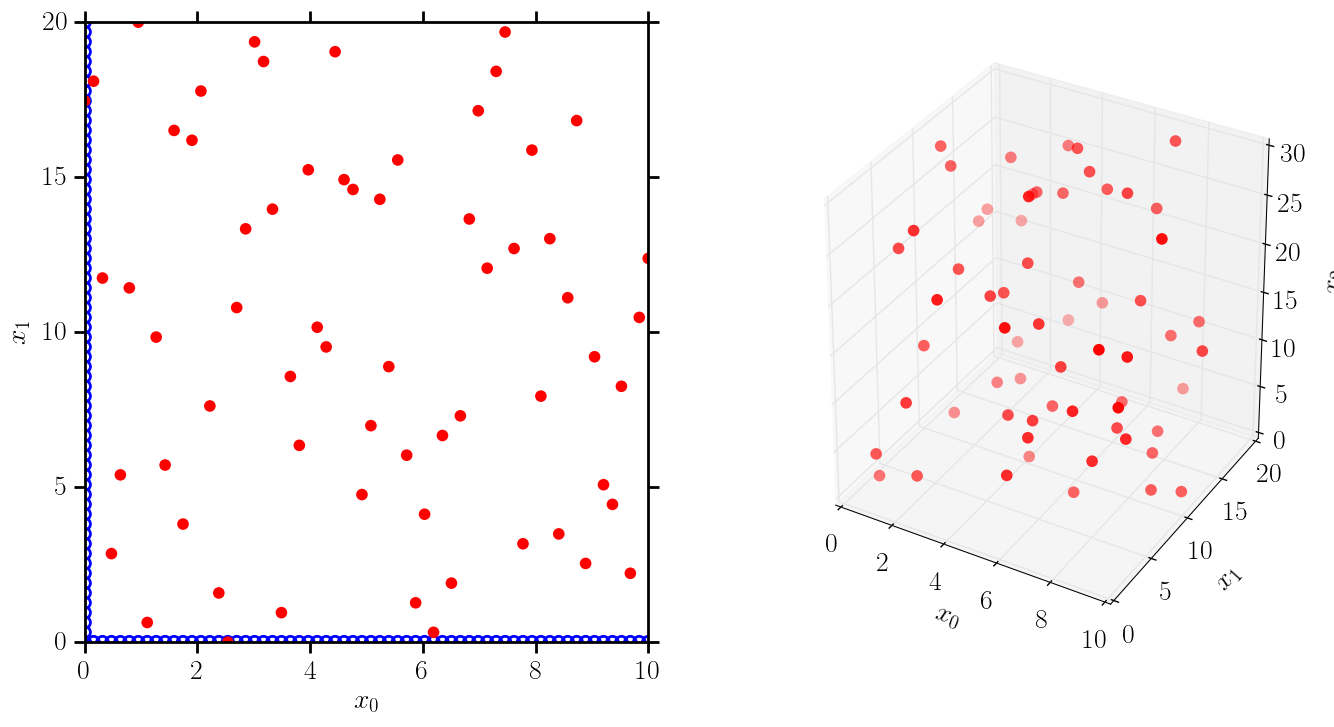

In [114]:
# Make 2d latin hypercube points
Ndata = 64
limits = np.array([[0, 10], [0, 20], [0, 30]])
points = gpr.latin_hypercube(Ndata, limits)

# ******* plot data *******
fig = plt.figure(figsize=(16, 8))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(121)

# for p in points[:, 0]:
#     axes.axvline(p, c='grey', lw=1)

# for p in points[:, 1]:
#     axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$x_0$')
axes.set_ylabel(r'$x_1$')


# ****** Full 3d data ******
axes = fig.add_subplot(122, projection='3d')

x, y, z = points[:, 0], points[:, 1], points[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_zlim(limits[2])
axes.set_xlabel(r'$x_0$', labelpad=10)
axes.set_ylabel(r'$x_1$', labelpad=15)
axes.set_zlabel(r'$x_2$', labelpad=18)

In [115]:
params = points

# Generate data
# def func(x, y, z):
#     return (np.sin(1.5*x*(1.0+0.05*x)) + 0.5*x + 10)*0.01*(y-5.0)**2 - 0.1*x*y + 0.02*z**2
def func(x, y, z):
    return (1.5*x*(1.0+0.05*x) + 0.5*x + 10)*0.01*(y-5.0)**2 - 0.1*x*y + 0.02*z**2

nparams = len(params)
sigma = 1.0e-3
data = np.array([func(params[i, 0], params[i, 1], params[i, 2]) for i in range(nparams)]) + np.random.normal(0.0, sigma, nparams)

data.min(), data.max()

(-3.4370982615724968, 55.442880068466629)

In [116]:
np.exp(10)**0.5, np.log(1.0e-3**2)

(148.4131591025766, -13.815510557964274)

In [117]:
ndim = 3
sigma_f = 3.0
sigma_n = 1.0e-3
l0 = 3
l1 = 10
l2 = 15
# Set up the kernel
k = sigma_f**2*kernels.ExpSquaredKernel([l0**2, l1**2, l2**2], ndim=ndim) + kernels.WhiteKernel(sigma_n**2, ndim=ndim)

# Set up the Gaussian process.
#gp = george.GP(k, solver=george.HODLRSolver)
gp = george.GP(k, solver=george.BasicSolver)

# You need to compute the GP once before starting the optimization.
gp.compute(params)

gp.kernel, np.exp(gp.kernel[:])**0.5, gp.kernel[:]

(ConstantKernel(9.0, ndim=3) * ExpSquaredKernel(9.0, 100.0, 225.0, ndim=3) + WhiteKernel(1e-06, ndim=3),
 array([  3.00000000e+00,   3.00000000e+00,   1.00000000e+01,
          1.50000000e+01,   1.00000000e-03]),
 array([  2.19722458,   2.19722458,   4.60517019,   5.4161004 , -13.81551056]))

In [118]:
def lnlike_gp(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(data, quiet=True)
    return ll

def lnprior_gp(p):
    lnsigmaf2, lnl02, lnl12, lnl22, lnsigman2 = p
    if not 0 < lnsigmaf2 < 8:
        return -np.inf
    if not -2 < lnl02 < 15:
        return -np.inf
    if not -2 < lnl12 < 15:
        return -np.inf
    if not -2 < lnl22 < 15:
        return -np.inf
    if not -20 < lnsigman2 < -4:
        return -np.inf
    return 0.0

# def lnprior_gp(p):
#     lnsigmaf2, lnl02, lnl12, lnsigman2 = p
#     if not 0 < lnsigmaf2 < 7:
#         return -np.inf
#     if not 0 < lnl02 < 10:
#         return -np.inf
#     if not 0 < lnl12 < 10:
#         return -np.inf
#     if not -20 < lnsigman2 < -4:
#         return -np.inf
#     return 0.0

def lnprob_gp(p):
    lp = lnprior_gp(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_gp(p)

In [119]:
lnprob_gp(np.array([1, 1, 1, 1, -6]))

-3425.1615620024304

In [123]:
nparams = 5
nwalkers = 256
nsteps = 1000
limits = np.array([[0, 8], [-2, 15], [-2, 15], [-2, 15], [-20, -4]])

p0 = gpr.uniform_random_samples(nwalkers, limits)
sampler = emcee.EnsembleSampler(nwalkers, nparams, lnprob_gp, threads=8)

t0 = time.clock()

# Run the production chain.
sampler.run_mcmc(p0, nsteps)

t1 = time.clock()
t1-t0

11.475659000000007

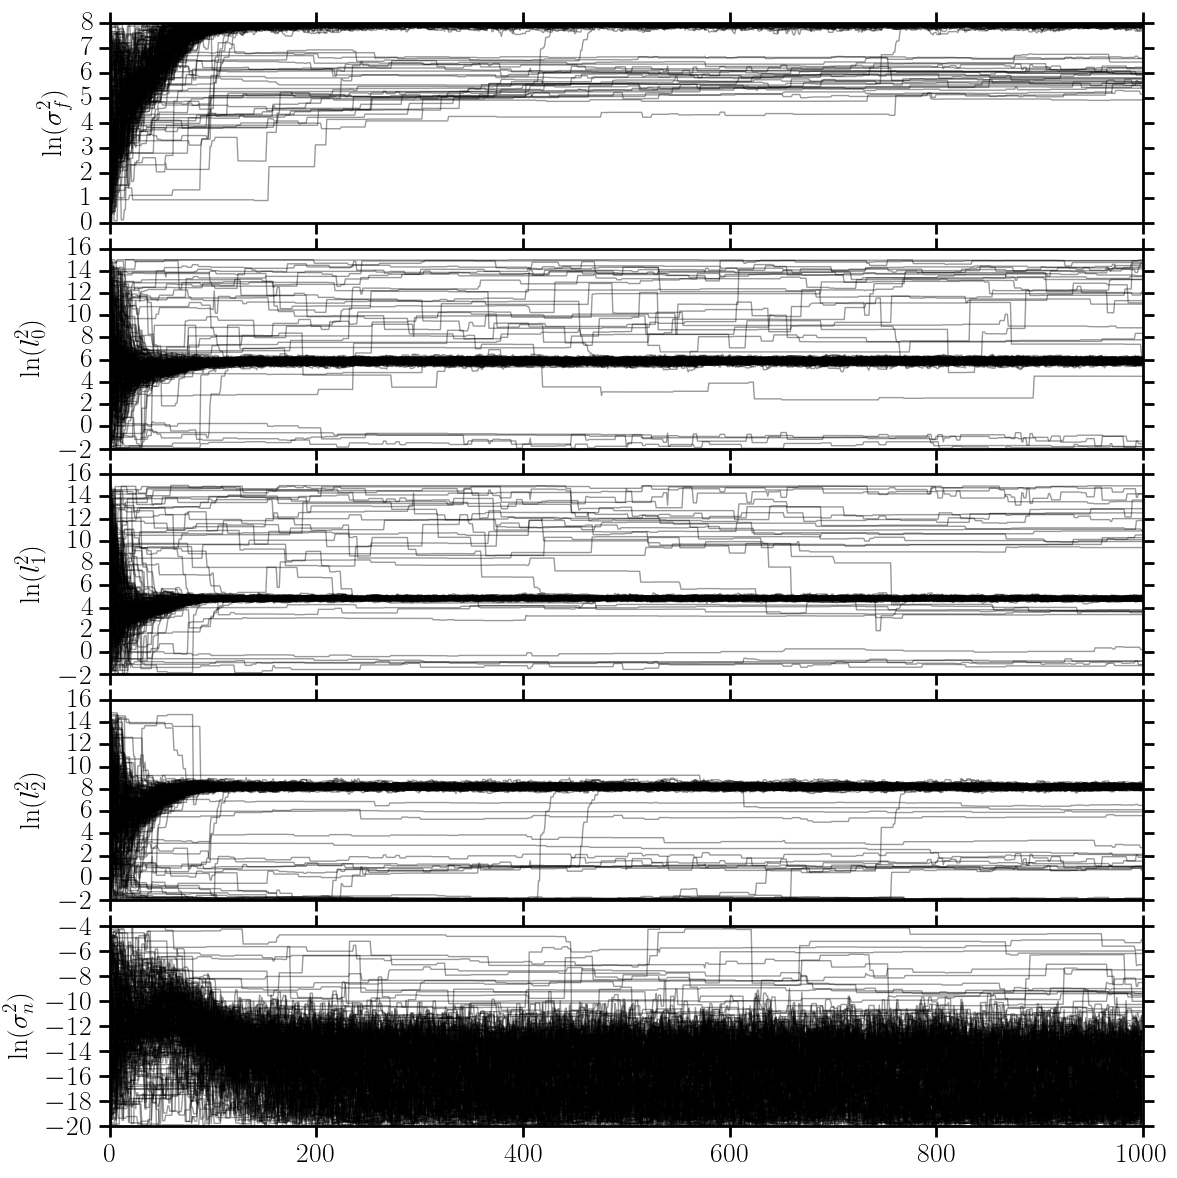

In [124]:
fig, axes = plt.subplots(nparams, 1, sharex=True, figsize=(12, 12))

labels = [r'$\ln(\sigma_f^2)$', r'$\ln(l_0^2)$', r'$\ln(l_1^2)$', r'$\ln(l_2^2)$', r'$\ln(\sigma_n^2)$']

for i in range(nparams):
    axes[i].plot(sampler.chain[:, :, i].T, color="k", alpha=0.4)
    axes[i].set_ylabel(labels[i])

fig.tight_layout(h_pad=0.0)

[  7.99987964   5.90735827   4.84421906   8.21331366 -19.09064764]
[  5.45948644e+01   1.91763766e+01   1.12696078e+01   6.07433026e+01
   7.15349928e-05]
-3.10508145804


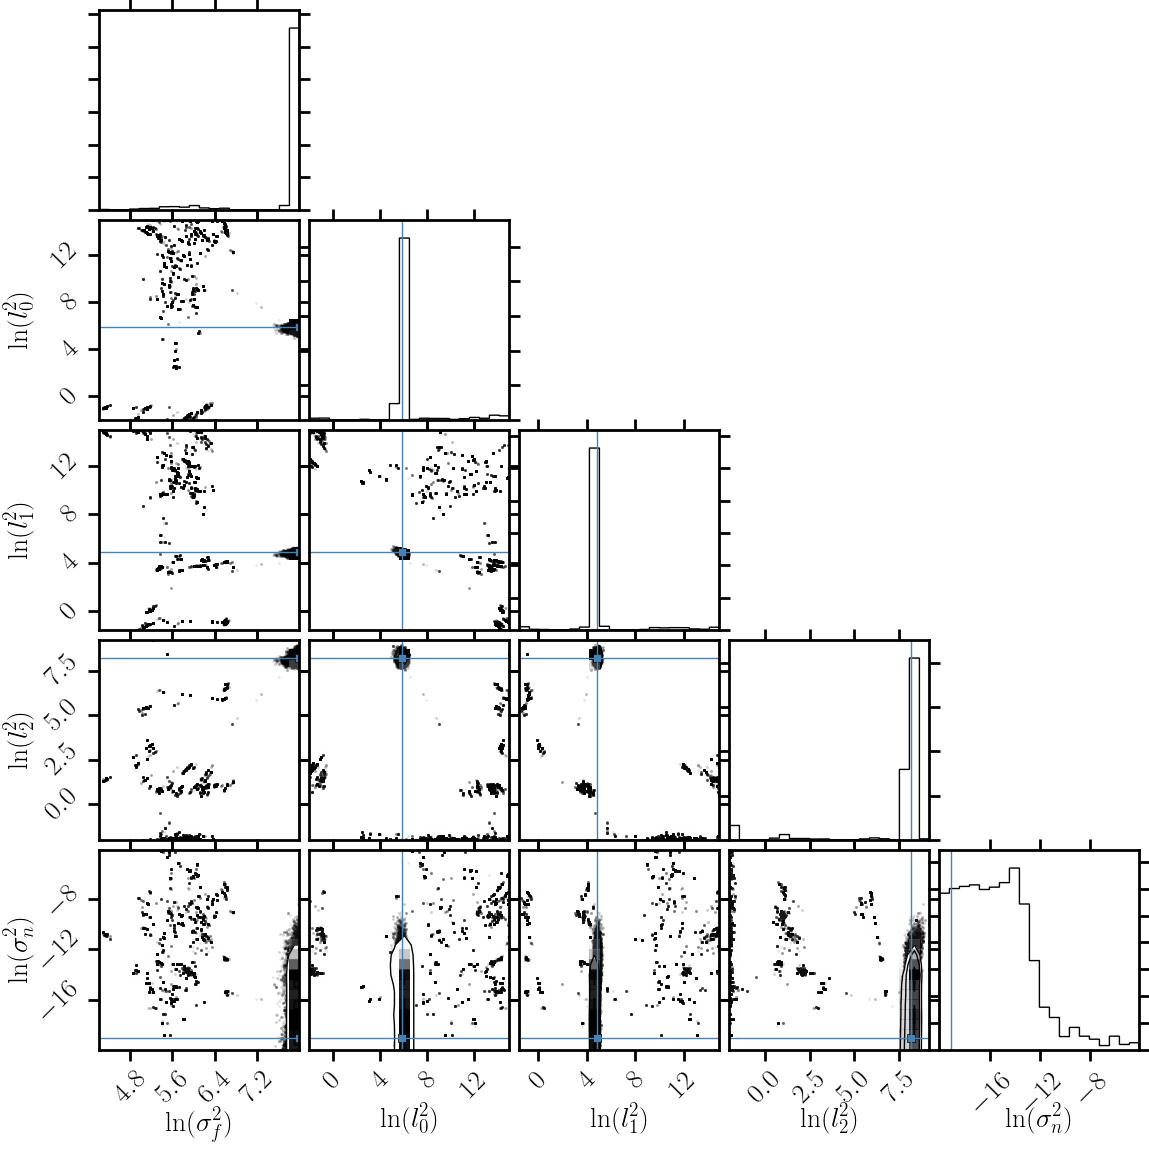

In [125]:
# Make the corner plot.
nburnin = 500
samples = sampler.chain[:, nburnin:, :].reshape((-1, nparams))

# Find Maximum likelihood
pmax, lnprobmax = max_lnprobability(sampler, nburnin=nburnin)
print pmax
print np.exp(pmax)**0.5
print lnprobmax

#samples = sampler.flatchain
labels = [r'$\ln(\sigma_f^2)$', r'$\ln(l_0^2)$', r'$\ln(l_1^2)$', r'$\ln(l_2^2)$', r'$\ln(\sigma_n^2)$']
fig = corner.corner(samples, truths=pmax, labels=labels)

In [126]:
pmax

array([  7.99987964,   5.90735827,   4.84421906,   8.21331366, -19.09064764])

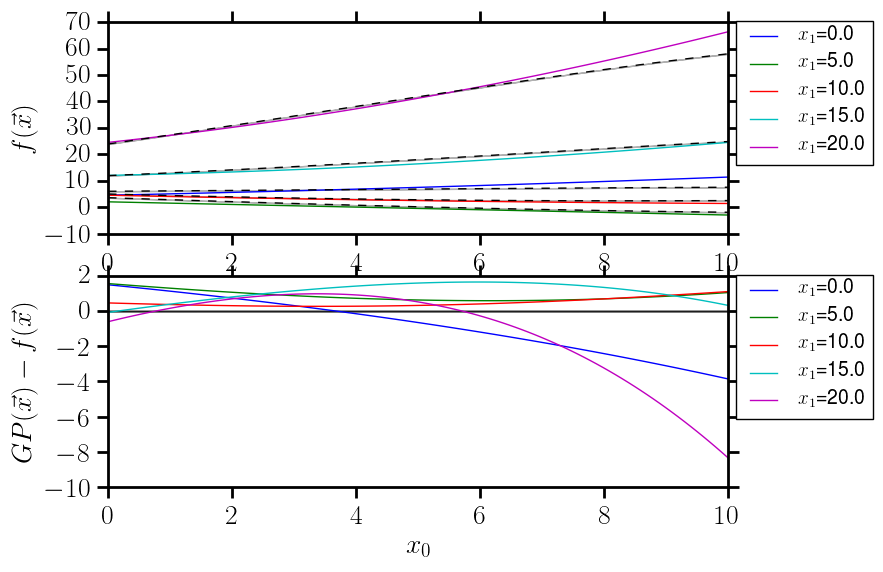

In [133]:
#gp.kernel[:] = pmax
gp.kernel[:] = array([  -5,   5.51981591,   5.14301705,   8.82602136, -10.68654858])
#gp.kernel[:] = array([  5,   5.51981591,   5.14301705,   8.82602136, -10.68654858])
gp.compute(params)

z = 10.0

fig, ax = plt.subplots(2, figsize=(8, 6))
for y in np.linspace(0, 20, 5):
    xs = np.linspace(0, 10, 100)
    ps = np.array([[x, y, z] for x in xs])
    
    true = np.array([func(p[0], p[1], p[2]) for p in ps])
    
    interp, cov = gp.predict(data, ps)
    interp_err = np.sqrt(np.diag(cov))
    
    ax[0].plot(xs, true, label=r'$x_1$='+str(y))
    ax[0].plot(xs, interp, c='k', ls='--')
    ax[0].fill_between(xs, interp-interp_err, interp+interp_err, color='k', alpha=0.3)
    
    ax[1].plot(xs, (interp-true), label=r'$x_1$='+str(y))
    ax[1].fill_between(xs, -interp_err, interp_err, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))

# 5D simple function with Latin hypercube sampling

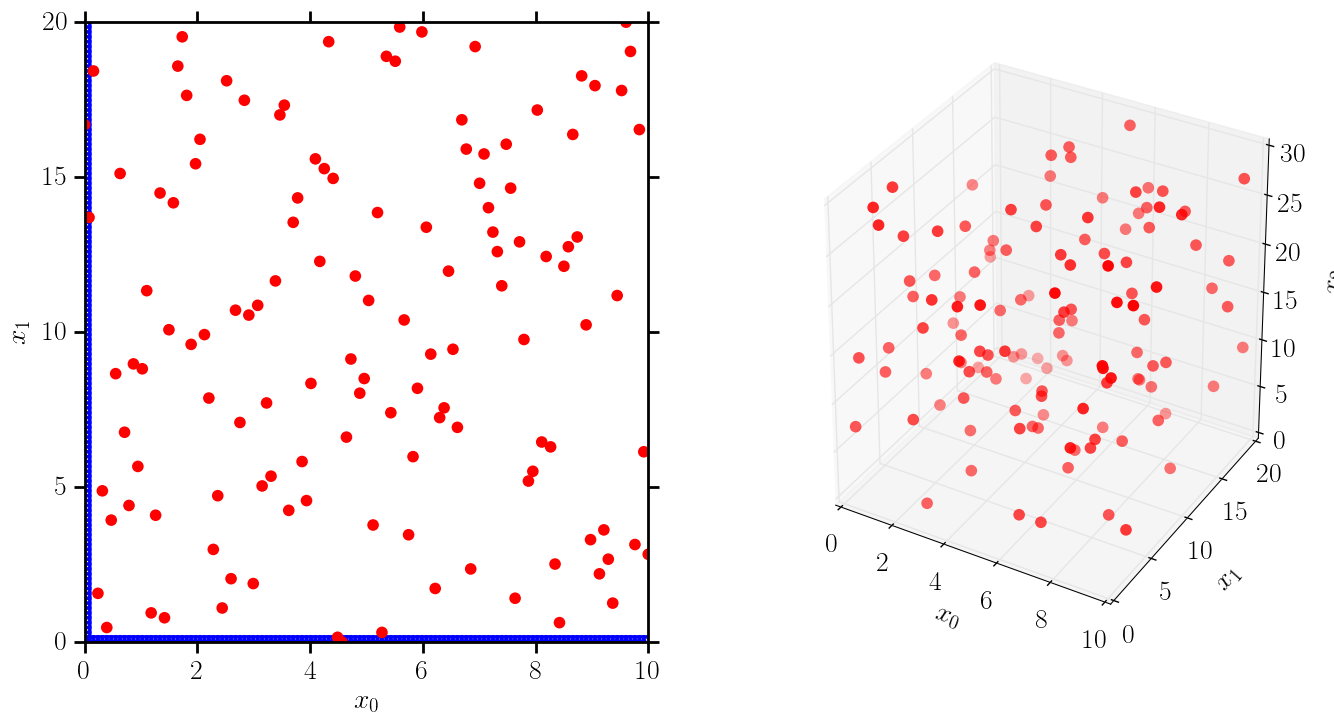

In [11]:
# Make 2d latin hypercube points
Ndata = 128
limits = np.array([[0, 10], [0, 20], [0, 30], [0, 40], [0, 50]])
points = gpr.latin_hypercube(Ndata, limits)

# ******* plot data *******
fig = plt.figure(figsize=(16, 8))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(121)

# for p in points[:, 0]:
#     axes.axvline(p, c='grey', lw=1)

# for p in points[:, 1]:
#     axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$x_0$')
axes.set_ylabel(r'$x_1$')


# ****** Full 3d data ******
axes = fig.add_subplot(122, projection='3d')

x, y, z = points[:, 0], points[:, 1], points[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_zlim(limits[2])
axes.set_xlabel(r'$x_0$', labelpad=10)
axes.set_ylabel(r'$x_1$', labelpad=15)
axes.set_zlabel(r'$x_2$', labelpad=18)

In [ ]:
params = points

# Generate data
# def func(x, y, z):
#     return (np.sin(1.5*x*(1.0+0.05*x)) + 0.5*x + 10)*0.01*(y-5.0)**2 - 0.1*x*y + 0.02*z**2
def func(x, y, z):
    return (np.sin(0.5*x*(1.0+0.05*x)) + 0.5*x + 10)*0.01*(y-5.0)**2 - 0.1*x*y + 0.02*z**2

nparams = len(params)
sigma = 1.0e-3
data = np.array([func(params[i, 0], params[i, 1], params[i, 2]) for i in range(nparams)]) + np.random.normal(0.0, sigma, nparams)

In [103]:
5**9

1953125